In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

     |████████████████████████████████| 1.1 MB 8.8 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 497.5 MB 24 kB/s 
     |████████████████████████████████| 462 kB 70.0 MB/s 


In [ ]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
#from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

### Initializing Actor-Critic Network

In [ ]:
class ActorCriticModel(tf.keras.Model):
    """
    Defining policy and value networkss
    """
    def __init__(self, action_size, n_hidden1=2048, n_hidden2=1536):
        super(ActorCriticModel, self).__init__()

        #Hidden Layer 1
        self.fc1 = tf.keras.layers.Dense(n_hidden1, activation='relu')
        #Hidden Layer 2
        self.fc2 = tf.keras.layers.Dense(n_hidden2, activation='relu')
      
        #Output Layer for policy
        self.pi_out = tf.keras.layers.Dense(action_size, activation='softmax')
        #Output Layer for state-value
        self.v_out = tf.keras.layers.Dense(1)

    def call(self, state):
        """
        Computes policy distribution and state-value for a given state
        """
        layer1 = self.fc1(state)
        layer2 = self.fc2(layer1)
       
        pi = self.pi_out(layer2)
        v = self.v_out(layer2)

        return pi, v

### Agent Class

In [ ]:
class Agent1:
    """
    Agent class
    """
    def __init__(self, action_size, lr=5e-6, gamma=0.99, seed = 85,n_hidden1=2048, n_hidden2=1536):
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size=action_size,n_hidden1=n_hidden1, n_hidden2=n_hidden2)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
        np.random.seed(seed)
    
    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi,_ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample()

        return int(sample.numpy()[0])

    def actor_loss(self, action, pi, delta):
        """
        Compute Actor Loss
        """
        return -tf.math.log(pi[0,action]) * delta

    def critic_loss(self,delta):
        """
        Critic loss aims to minimize TD error
        """
        return delta**2

    @tf.function
    def learn(self, state, action, reward, next_state, done):
        """
        For a given transition (s,a,s',r) update the paramters by computing the
        gradient of the total loss
        """
        with tf.GradientTape(persistent=True) as tape:
            pi, V_s = self.ac_model(state)
            _, V_s_next = self.ac_model(next_state)
            # V_s_next = tf.stop_gradient(V_s_next)

            V_s = tf.squeeze(V_s)
            V_s_next = tf.squeeze(V_s_next)
            
            #### TO DO: Write the equation for delta (TD error)
            ## Write code below
            delta = reward + (self.gamma * V_s_next) - V_s

            loss_a = self.actor_loss(action, pi, delta)
            loss_c =self.critic_loss(delta)
            loss_total = loss_a + loss_c

        gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
        self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))

# Acrobot-v1

In [6]:


#Initializing Agent
#agent = Agent1(lr=1e-4, action_size=env.action_space.n)
#Number of episodes
episodes = 3000
runs = 10
tf.compat.v1.reset_default_graph() #Should this be inside the run for loop??

env = gym.make('Acrobot-v1')
state = env.reset()   
runs_reward_list = []
runs_steps_list = []
required_episodes_to_solve_list = [episodes]*runs
#variance_list = []
step_count = 0
begin_time = datetime.datetime.now()

for run in range(10):
    #Initializing Agent
    
    n_hidden1=2048
    n_hidden2=1536
    lr=5e-6
    agent = Agent1(lr=lr, action_size=env.action_space.n,n_hidden1=n_hidden1, n_hidden2=n_hidden2)
    episodes_reward_list = []
    episodes_steps_list = []
    environment_solved = False
    print('begin experiment')
    for ep in range(1, episodes + 1):
        step_count = 0
        state = env.reset().reshape(1,-1)
        done = False
        ep_rew = 0
        while not done:
            action = agent.sample_action(state) ##Sample Action
            next_state, reward, done, info = env.step(action) ##Take action
            next_state = next_state.reshape(1,-1)
            ep_rew += reward  ##Updating episode reward
            agent.learn(state, action, reward, next_state, done) ##Update Parameters
            state = next_state ##Updating State
            step_count += 1
        episodes_reward_list.append(ep_rew)
        episodes_steps_list.append(step_count)

        if ep % 10 == 0:
            avg_rew = np.mean(episodes_reward_list[-10:])
            print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew, 'Step count %f' % step_count)

        if ep % 100 and environment_solved == False:
            avg_100 =  np.mean(episodes_reward_list[-100:])
            if avg_100 > env.spec.reward_threshold:
                print('Environment solved at Episode ',ep-100 if ep > 100 else ep)
                print('Average Reward for last 100 episodes: ', avg_100 )
                print('Threshold of the environment: ', env.spec.reward_threshold)
                #required_episodes_to_solve_list.append(ep-100)
                required_episodes_to_solve_list[run] = ep-100
                environment_solved = True
                break
    print('end experiment') 
    runs_reward_list.append(episodes_reward_list)
    runs_steps_list.append(episodes_steps_list)  
    
time_taken = datetime.datetime.now() - begin_time
print(time_taken)

begin experiment
Episode  10 Reward -451.000000 Average Reward -493.600000 Step count 452.000000
Episode  20 Reward -368.000000 Average Reward -370.400000 Step count 369.000000
Episode  30 Reward -370.000000 Average Reward -303.600000 Step count 371.000000
Episode  40 Reward -209.000000 Average Reward -273.400000 Step count 210.000000
Episode  50 Reward -176.000000 Average Reward -214.600000 Step count 177.000000
Episode  60 Reward -205.000000 Average Reward -219.100000 Step count 206.000000
Episode  70 Reward -167.000000 Average Reward -218.400000 Step count 168.000000
Episode  80 Reward -275.000000 Average Reward -222.400000 Step count 276.000000
Episode  90 Reward -177.000000 Average Reward -180.600000 Step count 178.000000
Episode  100 Reward -174.000000 Average Reward -224.200000 Step count 175.000000
Episode  110 Reward -151.000000 Average Reward -196.300000 Step count 152.000000
Episode  120 Reward -161.000000 Average Reward -199.400000 Step count 162.000000
Episode  130 Reward 

In [7]:
print(len(runs_reward_list))
print(len(runs_reward_list[0]))
print(np.average(runs_reward_list, 0).shape)
print(required_episodes_to_solve_list)
print(np.average(required_episodes_to_solve_list)) 

3
846
(2487,)
[746, 793, 648, 3000, 3000, 3000, 3000, 3000, 3000, 3000]
2318.7


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


In [8]:
maxEpisode=0
for i in runs_reward_list:
  if maxEpisode<len(i):
    maxEpisode=len(i)

In [9]:
r_reward_ist=runs_reward_list

In [10]:
def average(x):
    #print('x before: ', x)
    y = [i for i in x if i is not None]
    #print(y)
    return sum(y, 0.0) / len(y)

def variance(x):
    z = [i for i in x if i is not None]
    #print(z)
    return np.var(z)


import itertools as it
average_steps_to_goal_across_runs_for_each_episode = list(map(average, it.zip_longest(*runs_steps_list) ))

average_total_reward_across_runs_for_each_episode = list(map(average, it.zip_longest(*runs_reward_list) ))

variance_of_total_episode_reward_across_runs_for_each_episode = list(map(variance, it.zip_longest(*runs_reward_list) ))

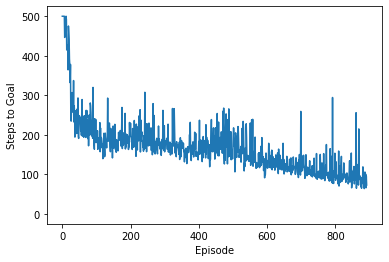

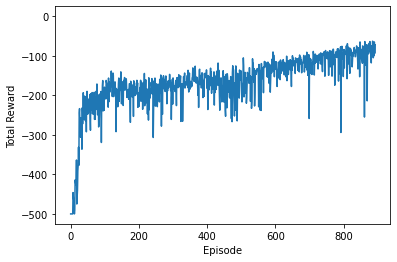

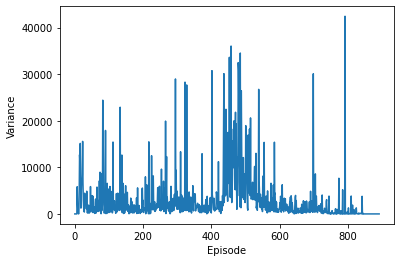

In [11]:
plt.xlabel('Episode')
plt.ylabel('Steps to Goal')

plt.plot(np.arange(len(average_steps_to_goal_across_runs_for_each_episode)),average_steps_to_goal_across_runs_for_each_episode, 0)
plt.show()

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(len(average_total_reward_across_runs_for_each_episode)),average_total_reward_across_runs_for_each_episode, 0)
plt.show()

plt.xlabel('Episode')
plt.ylabel('Variance')
plt.plot(np.arange(len(variance_of_total_episode_reward_across_runs_for_each_episode)),variance_of_total_episode_reward_across_runs_for_each_episode , 0)
plt.show()